## PINN Implementation: Solving the Poisson Equation

Solving the 1D Poisson equation:
$$-\frac{d^2u}{dx^2} = f(x), \quad x \in [0,1]$$

with boundary conditions $u(0) = u(1) = 0$ and manufactured solution $u(x) = \sin(\pi x)$, giving $f(x) = \pi^2 \sin(\pi x)$.

In [4]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots  # optional, requires latex
import numpy as np
plt.style.use(['science', 'grid'])
from phd.plot import book_config, get_current_config as plt_cfg
book_config.set_as_current()

results_folder = '../results/II_PINNs'  
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# --- Figure settings ---
save_fig = True
if save_fig:
    mpl.rcParams['pgf.texsystem'] = 'pdflatex'

In [2]:
import jax
import jax.numpy as jnp
from jax import grad # gradient function using Autodiff

# Manufactured solution and source term
u_exact = lambda x: jnp.sin(jnp.pi * x)
f_source = lambda x: jnp.pi**2 * jnp.sin(jnp.pi * x)

# Initialize parameters
key = jax.random.PRNGKey(0) # random seed
scale = jnp.sqrt(2.0 / (1 + 32))
W1 = scale * jax.random.normal(key, (1, 32)); b1 = jnp.zeros(32)
W2 = scale * jax.random.normal(key, (32, 1)); b2 = jnp.zeros(1)
theta = (W1, b1, W2, b2) # Initial parameters

def u_tilde(x, theta): # Neural network approximation
    W1, b1, W2, b2 = theta
    return (jnp.tanh(jnp.array([x]) @ W1 + b1) @ W2 + b2)[0]

du_dx = lambda x, theta: grad(u_tilde)(x, theta) # first derivative
d2u_dx2 = lambda x, theta: grad(du_dx)(x, theta) # second derivative

import optax
from jax import jit, vmap # map functions over arrays

def loss_fn(theta, x_pde, x_bc, u_bc):
    L_pde_func = lambda x: (-d2u_dx2(x, theta) - f_source(x))**2
    L_bc_func = lambda x: (u_tilde(x, theta) - u_bc)**2
    L_pde = jnp.mean(vmap(L_pde_func)(x_pde)) # mapped over x_pde
    L_bc  = jnp.mean(vmap(L_bc_func)(x_bc)) # mapped over x_bc
    return L_pde + L_bc

optimizer = optax.adam(1e-3) # Adam optimizer with learning rate 1e-3
opt_state = optimizer.init(theta) 

@jit # JIT compile the training step
def train_step(theta, opt_state, x_pde, x_bc, u_bc):
    loss_val, grads = jax.value_and_grad(loss_fn)(theta, x_pde, x_bc, u_bc) 
    updates, opt_state = optimizer.update(grads, opt_state)
    theta = optax.apply_updates(theta, updates)
    return theta, opt_state, loss_val

# N_pde = 100
# x_pde = jax.random.uniform(key, (N_pde,)) # Collocation points
# x_bc = jnp.array([0.0, 1.0]) # Boundary points
# u_bc = vmap(u_exact)(x_bc) # Exact boundary values (0, 0)
# for epoch in range(10_001):
#     theta, opt_state, loss_val = train_step(theta, opt_state,x_pde, x_bc, u_bc)
#     if epoch % 1000 == 0:
#         print(f"Epoch {epoch:5d}| Loss: {loss_val:.4e}")

W0108 17:14:22.320292   18007 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0108 17:14:22.324197   17895 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [3]:
# Collocation and test points
N_pde = 100
x_pde = jax.random.uniform(key, (N_pde,))
x_bc = jnp.array([0.0, 1.0])
u_bc = vmap(u_exact)(x_bc)
x_test = jnp.linspace(0, 1, 100)
u_test_exact = vmap(u_exact)(x_test)
history = {'Epoch': [], 'Loss': [], 'L2 Error': [], 'Solution': []}
n_epochs = 10_001
for epoch in range(n_epochs):
    theta, opt_state, loss_val = train_step(theta, opt_state,x_pde, x_bc, u_bc)
    if epoch % 25 == 0:
        u_pred = vmap(lambda x: u_tilde(x, theta))(x_test)
        l2_error = jnp.sqrt(jnp.mean((u_pred - u_test_exact)**2))
        history['Epoch'].append(epoch)
        history['Loss'].append(loss_val)
        history['L2 Error'].append(l2_error)
        history['Solution'].append(u_pred)
    if epoch % 1000 == 0:
        print(f"Epoch {epoch:5d}| Loss: {loss_val:.4e}| L2 Error: {l2_error:.4e}")

Epoch     0| Loss: 4.7239e+01| L2 Error: 9.2381e-01
Epoch  1000| Loss: 9.6209e-01| L2 Error: 4.6871e-02
Epoch  2000| Loss: 1.7456e-01| L2 Error: 5.3600e-02
Epoch  3000| Loss: 5.9793e-02| L2 Error: 1.6715e-02
Epoch  4000| Loss: 2.6636e-02| L2 Error: 1.0971e-02
Epoch  5000| Loss: 1.2141e-02| L2 Error: 6.2092e-03
Epoch  6000| Loss: 5.1963e-03| L2 Error: 3.5448e-03
Epoch  7000| Loss: 2.5310e-03| L2 Error: 1.6100e-03
Epoch  8000| Loss: 1.5058e-03| L2 Error: 1.2327e-03
Epoch  9000| Loss: 9.6919e-04| L2 Error: 8.2883e-04
Epoch 10000| Loss: 7.1314e-04| L2 Error: 6.4962e-04


## Results

/tmp/ipykernel_17895/677541369.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels([f'{i//1000}k' for i in np.arange(0, n_epochs+1, 2000)])


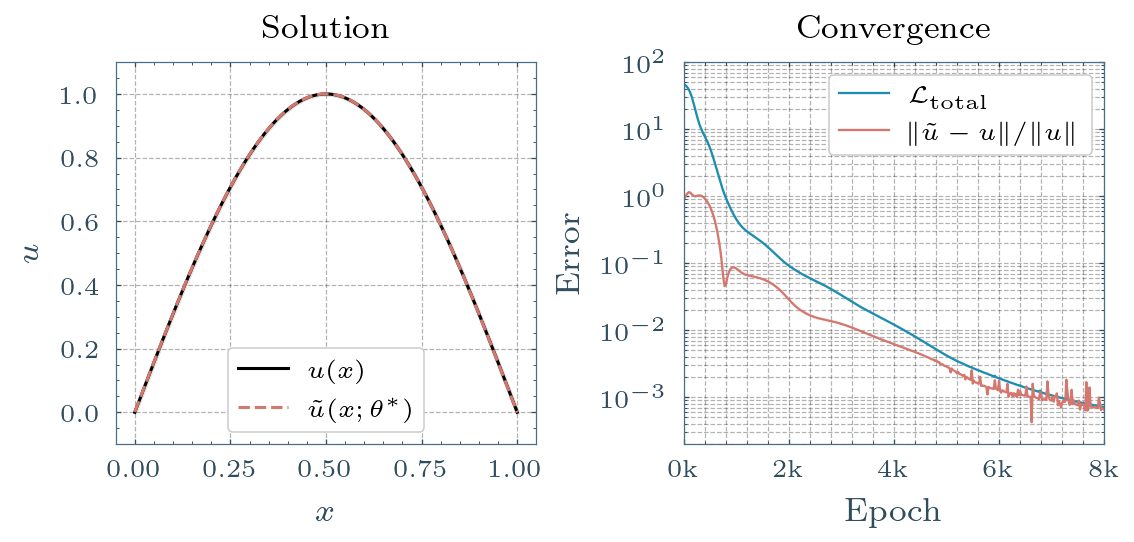

Saved: ../results/II_PINNs/images/pinn_poisson_1d.png + .pgf


In [13]:
# Animate training: evolution of ũ(x;θ) during epochs
from matplotlib.animation import FuncAnimation
from itertools import chain

page_width = plt_cfg().page_width
plotting_factor = 1/plt_cfg().scale

def init_figure(theta_str="\\theta"):
    """Initialize figure and static plot elements."""
    fig, axes = plt.subplots(1, 2, figsize=(page_width*0.9, page_width*0.35), dpi=300)
    fig.subplots_adjust(wspace=0.35)
    
    # LEFT: Solution plot setup
    axes[0].plot(x_test, u_test_exact, 'k-', linewidth=2/plotting_factor, label=r'$u(x)$')
    line_pred, = axes[0].plot([], [], 'C1--', linewidth=2/plotting_factor, label=r"$\tilde{u}(x;"+f"{theta_str})$")
    axes[0].set_xlabel(r'$x$'); axes[0].set_ylabel(r'$u$'); axes[0].set_ylim([-0.1, 1.1])
    axes[0].set_title('Solution'); axes[0].legend().get_frame().set_linewidth(plt_cfg().scale)
    axes[0].grid(True, alpha=0.3)
    epoch_text = axes[0].text(0.035, 0.965, '', transform=axes[0].transAxes, fontsize=5,
                              va='top', ha='left', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0))
    
    # RIGHT: Convergence plot setup
    line_loss, = axes[1].semilogy([], [], '-', label=r'$\mathcal{L}_{\mathrm{total}}$', 
                                   color='C0', linewidth=1.5/plotting_factor)
    line_l2, = axes[1].semilogy([], [], '-', label=r'$\|\tilde{u}-u\|/\|u\|$',
                                color='C1', linewidth=1.5/plotting_factor)
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Error')
    axes[1].set_xlim([0, n_epochs]); axes[1].set_ylim([2e-4, 1e2])
    axes[1].set_title('Convergence'); axes[1].legend().get_frame().set_linewidth(plt_cfg().scale)
    axes[1].grid(True, alpha=0.3, which='both')
    # axes[1].set_xticks(np.arange(0, n_epochs+1, 2000))
    axes[1].set_xticklabels([f'{i//1000}k' for i in np.arange(0, n_epochs+1, 2000)])
    
    return fig, axes, {'line_pred': line_pred, 'line_loss': line_loss, 'line_l2': line_l2, 
                       'epoch_text': epoch_text, 'fill_obj': None}

def update_plot(frame_idx, artists):
    """Update plot with data from given frame index."""
    u_frame = history['Solution'][frame_idx]
    epoch_frame = history['Epoch'][frame_idx]
    
    # Update solution and error fill
    artists['line_pred'].set_data(x_test, u_frame)
    if artists['fill_obj'] is not None:
        artists['fill_obj'].remove()
    artists['fill_obj'] = artists['line_pred'].axes.fill_between(x_test, u_test_exact, u_frame, 
                                                                   alpha=0.2, color='gray')
    
    # Update epoch text
    artists['epoch_text'].set_text(f"Epoch: {(epoch_frame + 1) / 1000:.1f}k")
    
    # Update convergence curves
    epochs_subset = np.array(history['Epoch'][:frame_idx+1])
    artists['line_loss'].set_data(epochs_subset, np.array(history['Loss'][:frame_idx+1]))
    artists['line_l2'].set_data(epochs_subset, np.array(history['L2 Error'][:frame_idx+1]))

    return artists['line_pred'], artists['epoch_text'], artists['line_loss'], artists['line_l2'], artists['fill_obj']

# Static plot for saving
fig_static, axes_static, artists_static = init_figure("\\theta^*")
update_plot(len(history['Epoch']) - 1, artists_static)
artists_static['epoch_text'].set_text('')
plt.show()

if save_fig:
    fig_static.savefig(os.path.join('./images', 'pinn_poisson_1d.png'), dpi=300, bbox_inches='tight')
    fig_static.savefig(os.path.join('./images/pgf', 'pinn_poisson_1d.pgf'), bbox_inches='tight')
    print(f"Saved: {os.path.join(results_folder, 'images', 'pinn_poisson_1d.png')} + .pgf")

Animation: 156 frames at 10 fps = 15.6s


/tmp/ipykernel_17895/677541369.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels([f'{i//1000}k' for i in np.arange(0, n_epochs+1, 2000)])


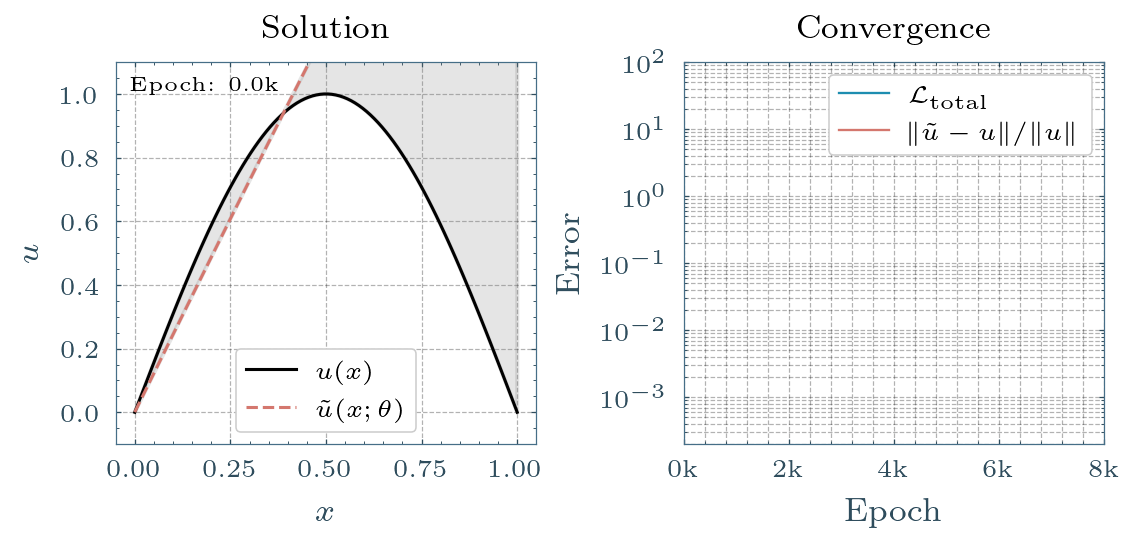

In [14]:
# Animation
def subsample_steps(steps, sub_factors):
    section_ends = [int(len(steps) * i / len(sub_factors)) for i in range(1, len(sub_factors) + 1)]
    return list(chain.from_iterable([range(section_ends[i-1] if i > 0 else 0, section_ends[i], factor) 
                                      for i, factor in enumerate(sub_factors)]))

# Prepare frame indices
frame_steps = subsample_steps(list(range(len(history['Epoch']))), [1, 2, 3, 4, 5, 5, 5])
fps = 10
print(f"Animation: {len(frame_steps)} frames at {fps} fps = {len(frame_steps)/fps:.1f}s")

fig_anim, axes_anim, artists_anim = init_figure()
anim = FuncAnimation(fig_anim, lambda i: update_plot(frame_steps[i], artists_anim), 
                     frames=len(frame_steps), repeat=True, interval=100, blit=True)
plt.show()

# Uncomment to save:
anim.save(os.path.join('./images', 'pinn_poisson_1d.gif'), writer='pillow', fps=fps)

## DeepXDE Implementation (Compact)

Compiling model...
'compile' took 0.015290 s



Training model...

Step      Train loss              Test loss               Test metric   
0         [4.78e+01, 1.59e-04]    [4.91e+01, 1.59e-04]    [1.01e+00]    
1000      [9.48e-04, 3.69e-06]    [7.60e-04, 3.69e-06]    [1.70e-03]    
2000      [5.16e-04, 5.84e-07]    [4.01e-04, 5.84e-07]    [7.31e-04]    
3000      [1.67e-04, 1.52e-07]    [1.18e-04, 1.52e-07]    [3.87e-04]    
4000      [4.77e-05, 1.08e-08]    [3.56e-05, 1.08e-08]    [1.06e-04]    
5000      [4.09e-05, 3.05e-09]    [3.28e-05, 3.05e-09]    [6.70e-05]    
6000      [5.51e-05, 1.01e-06]    [4.70e-05, 1.01e-06]    [1.11e-03]    
7000      [3.33e-05, 5.78e-10]    [2.71e-05, 5.78e-10]    [3.48e-05]    
8000      [9.49e-05, 3.83e-06]    [8.81e-05, 3.83e-06]    [2.00e-03]    
9000      [5.42e-05, 9.30e-07]    [4.94e-05, 9.30e-07]    [1.99e-03]    
10000     [7.09e-04, 3.09e-05]    [6.97e-04, 3.09e-05]    [5.34e-03]    

Best model at step 7000:
  train loss: 3.33e-05
  test loss: 2.71e-05
  test metric: [3.48e-05]

'train'

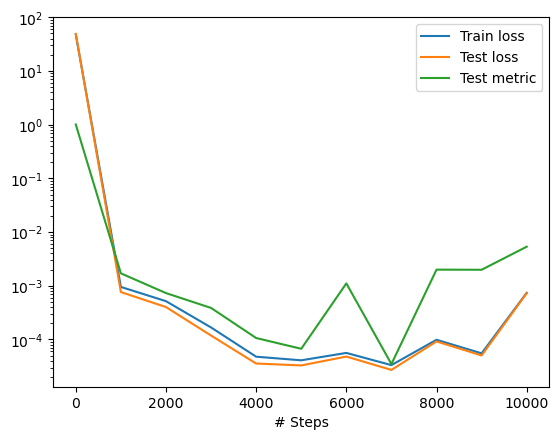

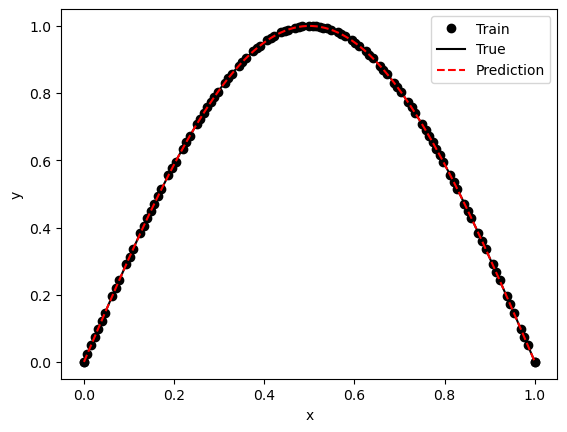

In [ ]:
import deepxde as dde
import numpy as np
import jax.numpy as jnp

# Manufactured solution and source term
u_exact = lambda x: np.sin(np.pi * x)
f_source = lambda x: jnp.pi**2 * jnp.sin(jnp.pi * x)

# PDE: -u_xx = π²sin(πx)
def pde(x, y):
    dy_xx, _ = dde.grad.hessian(y, x)
    return -dy_xx - f_source(x)

# Geometry and BCs
geom = dde.geometry.Interval(0, 1)
bc = dde.icbc.DirichletBC(geom, u_exact, lambda x, on_boundary: on_boundary)

data = dde.data.PDE(geom, pde, bc, 100, 2, solution=u_exact, num_test=100)
net = dde.nn.FNN([1, 32, 32, 1], "tanh", "Glorot normal")

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=False, isplot=True)